# Dependencies

## Modules

In [1]:
!pip install --no-cache-dir torch transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 479.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 220.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 604.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 554.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.9
    Uninstalling dill-0.3.9:
      Successfully uninstalled dill-0.3.9
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.17
    Uninstalling multiprocess-0.70.17:
      Successfully uninstalled multiprocess-0.70.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pathos 0.3.3 requi

In [2]:
!pip install --no-cache-dir seqeval==1.2.2 --use-pep517

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=af34fd47a2bff0ffe958d42f0e316643891ceee92bd3559682e671974b32561c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ih2hklqw/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
!pip install --no-cache-dir optuna

In [23]:
!pip install --no-cache-dir torchviz


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Imports

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW
from transformers import AutoModel, AutoTokenizer, get_scheduler
from datasets import load_dataset
from tqdm import tqdm
from seqeval.metrics import classification_report
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

# Dataset

In [5]:
# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003")
label_list = dataset["train"].features["ner_tags"].feature.names
num_labels = len(label_list)

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [6]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Tokenization and alignment
def tokenize_and_align_labels(batch):
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(batch["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = [-100 if word_id is None else label[word_id] for word_id in word_ids]
        labels.append(aligned_labels)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [7]:
# DataLoader collate function
def collate_fn(batch):
    input_ids = [torch.tensor(x["input_ids"]) for x in batch]
    attention_mask = [torch.tensor(x["attention_mask"]) for x in batch]
    labels = [torch.tensor(x["labels"]) for x in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded,
        "labels": labels_padded,
    }

train_loader = DataLoader(tokenized_datasets["train"], batch_size=16, collate_fn=collate_fn)
val_loader = DataLoader(tokenized_datasets["validation"], batch_size=16, collate_fn=collate_fn)

# Model

## Training

In [8]:
class BertForNERWithLayerAttention(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(BertForNERWithLayerAttention, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name, output_hidden_states=True)
        self.num_hidden_layers = self.bert.config.num_hidden_layers + 1 
        self.layer_weights = nn.Parameter(torch.ones(self.num_hidden_layers))
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = torch.stack(outputs.hidden_states, dim=0)  # (num_layers, batch_size, seq_len, hidden_size)
        weighted_hidden_states = torch.sum(self.layer_weights[:, None, None, None] * hidden_states, dim=0)
        sequence_output = self.dropout(weighted_hidden_states)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, logits.size(-1))[active_loss]
            active_labels = labels.view(-1)[active_loss]
            loss = loss_fn(active_logits, active_labels)

        return {"loss": loss, "logits": logits}

In [9]:
# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForNERWithLayerAttention(pretrained_model_name="bert-base-cased", num_labels=num_labels).to(device)
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
# Training Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader)}")

Epoch 1: 100%|██████████| 878/878 [01:15<00:00, 11.65it/s]


Epoch 1 Loss: 0.5253659653293948


Epoch 2: 100%|██████████| 878/878 [00:49<00:00, 17.82it/s]


Epoch 2 Loss: 0.1434093017832039


Epoch 3: 100%|██████████| 878/878 [00:49<00:00, 17.78it/s]

Epoch 3 Loss: 0.06444175787890495


## Evaluation

In [11]:
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        preds = torch.argmax(logits, dim=-1)

        for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
            predictions.append([label_list[p] for p, l in zip(pred, label) if l != -100])
            true_labels.append([label_list[l] for p, l in zip(pred, label) if l != -100])

print(classification_report(true_labels, predictions))

Evaluating: 100%|██████████| 204/204 [00:04<00:00, 46.10it/s]


              precision    recall  f1-score   support

         LOC       0.95      0.94      0.94      3635
        MISC       0.80      0.85      0.82      1480
         ORG       0.91      0.89      0.90      2702
         PER       0.96      0.93      0.95      3329

   micro avg       0.92      0.91      0.92     11146
   macro avg       0.90      0.90      0.90     11146
weighted avg       0.92      0.91      0.92     11146



## Hyperparameter Tuning

### Optuna Study

In [12]:
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    num_epochs = 3

    # Define model with trial's hyperparameters
    class BertForNER(nn.Module):
        def __init__(self, pretrained_model_name, num_labels):
            super(BertForNER, self).__init__()
            self.bert = AutoModel.from_pretrained(pretrained_model_name, output_hidden_states=True)
            self.num_hidden_layers = self.bert.config.num_hidden_layers + 1
            self.layer_weights = nn.Parameter(torch.ones(self.num_hidden_layers))
            self.dropout = nn.Dropout(dropout_rate)  # Use trial's dropout rate
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        def forward(self, input_ids, attention_mask, labels=None):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = torch.stack(outputs.hidden_states, dim=0)  # (num_layers, batch_size, seq_len, hidden_size)
            weighted_hidden_states = torch.sum(self.layer_weights[:, None, None, None] * hidden_states, dim=0)
            sequence_output = self.dropout(weighted_hidden_states)
            logits = self.classifier(sequence_output)

            loss = None
            if labels is not None:
                loss_fn = nn.CrossEntropyLoss()
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, logits.size(-1))[active_loss]
                active_labels = labels.view(-1)[active_loss]
                loss = loss_fn(active_logits, active_labels)

            return {"loss": loss, "logits": logits}

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BertForNER(pretrained_model_name="bert-base-cased", num_labels=num_labels).to(device)

    # Define optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Prepare data loaders
    train_loader = DataLoader(tokenized_datasets["train"], batch_size=batch_size, collate_fn=collate_fn)
    val_loader = DataLoader(tokenized_datasets["validation"], batch_size=batch_size, collate_fn=collate_fn)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            preds = torch.argmax(logits, dim=-1)

            for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
                predictions.append([label_list[p] for p, l in zip(pred, label) if l != -100])
                true_labels.append([label_list[l] for p, l in zip(pred, label) if l != -100])

    # Compute F1-score
    f1 = f1_score([label for seq in true_labels for label in seq],
                  [label for seq in predictions for label in seq],
                  average="weighted")
    return f1

In [13]:
# Create Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # Try 20 different combinations

# Print best parameters
print("Best hyperparameters:", study.best_params)

[I 2024-12-09 20:26:33,093] A new study created in memory with name: no-name-d3fd9897-1d25-4f9d-a5f9-684f1f3e0da8
/tmp/ipykernel_15366/3088590689.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipykernel_15366/3088590689.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
Epoch 3: 100%|██████████| 1756/1756 [01:18<00:00, 22.27it/s]
[I 2024-12-09 20:30:36,510] Trial 0 finished with value: 0.9625228572100585 and parameters: {'learning_rate': 0.000141150884172717, 'dropout_rate': 0.11722622565477665, 'batch_size': 8}. Best is trial 0 with value: 0.962

Best hyperparameters: {'learning_rate': 4.369484270668493e-05, 'dropout_rate': 0.33027803609683487, 'batch_size': 32}


## Best Model

In [16]:
learning_rate = 4.369484270668493e-05
dropout_rate = 0.33027803609683487
batch_size = 32
num_epochs = 50

In [14]:
# Define the final model
class BertForFinalNER(nn.Module):
    def __init__(self, pretrained_model_name, num_labels, dropout_rate):
        super(BertForFinalNER, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name, output_hidden_states=True)
        self.num_hidden_layers = self.bert.config.num_hidden_layers + 1
        self.layer_weights = nn.Parameter(torch.ones(self.num_hidden_layers))
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = torch.stack(outputs.hidden_states, dim=0)
        weighted_hidden_states = torch.sum(self.layer_weights[:, None, None, None] * hidden_states, dim=0)
        sequence_output = self.dropout(weighted_hidden_states)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, logits.size(-1))[active_loss]
            active_labels = labels.view(-1)[active_loss]
            loss = loss_fn(active_logits, active_labels)

        return {"loss": loss, "logits": logits}

### Training

Training Epoch 1: 100%|██████████| 439/439 [00:40<00:00, 10.85it/s]


Epoch 1 Training Loss: 0.7099
Epoch 1 Validation Loss: 0.1487
Validation loss improved to 0.1487.


Training Epoch 2: 100%|██████████| 439/439 [00:40<00:00, 10.82it/s]


Epoch 2 Training Loss: 0.1706
Epoch 2 Validation Loss: 0.1111
Validation loss improved to 0.1111.


Training Epoch 3: 100%|██████████| 439/439 [00:40<00:00, 10.82it/s]


Epoch 3 Training Loss: 0.0782
Epoch 3 Validation Loss: 0.1114
No improvement for 1 epochs.


Training Epoch 4: 100%|██████████| 439/439 [00:40<00:00, 10.82it/s]


Epoch 4 Training Loss: 0.0502
Epoch 4 Validation Loss: 0.1184
No improvement for 2 epochs.


Training Epoch 5: 100%|██████████| 439/439 [00:40<00:00, 10.81it/s]


Epoch 5 Training Loss: 0.0325
Epoch 5 Validation Loss: 0.1265
No improvement for 3 epochs.


Training Epoch 6: 100%|██████████| 439/439 [00:40<00:00, 10.81it/s]


Epoch 6 Training Loss: 0.0249
Epoch 6 Validation Loss: 0.1305
No improvement for 4 epochs.


Training Epoch 7: 100%|██████████| 439/439 [00:40<00:00, 10.84it/s]


Epoch 7 Training Loss: 0.0197
Epoch 7 Validation Loss: 0.1318
No improvement for 5 epochs.


Training Epoch 8: 100%|██████████| 439/439 [00:40<00:00, 10.85it/s]


Epoch 8 Training Loss: 0.0127
Epoch 8 Validation Loss: 0.1487
No improvement for 6 epochs.


Training Epoch 9: 100%|██████████| 439/439 [00:40<00:00, 10.85it/s]


Epoch 9 Training Loss: 0.0116
Epoch 9 Validation Loss: 0.1443
No improvement for 7 epochs.


Training Epoch 10: 100%|██████████| 439/439 [00:40<00:00, 10.84it/s]


Epoch 10 Training Loss: 0.0121
Epoch 10 Validation Loss: 0.1519
No improvement for 8 epochs.


Training Epoch 11: 100%|██████████| 439/439 [00:40<00:00, 10.84it/s]


Epoch 11 Training Loss: 0.0131
Epoch 11 Validation Loss: 0.1428
No improvement for 9 epochs.


Training Epoch 12: 100%|██████████| 439/439 [00:40<00:00, 10.85it/s]


Epoch 12 Training Loss: 0.0064
Epoch 12 Validation Loss: 0.1275
No improvement for 10 epochs.
Early stopping triggered. Training stopped.


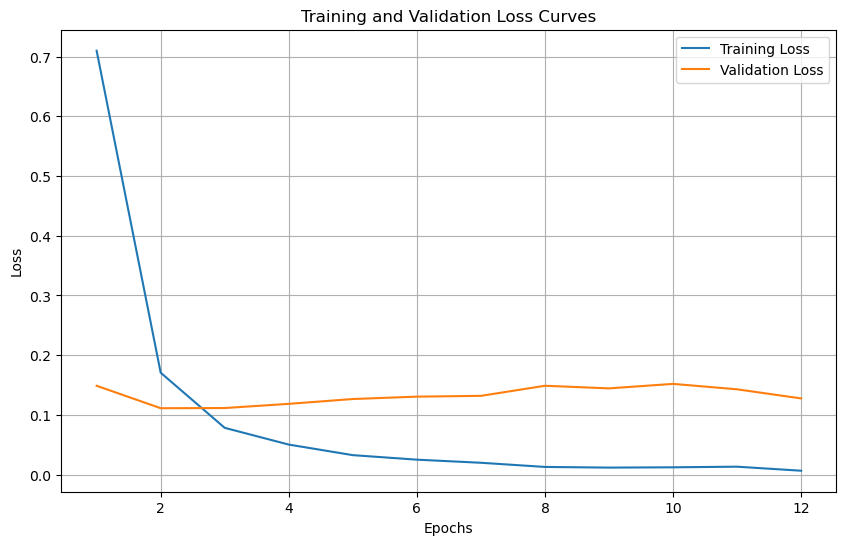

In [17]:
# Instantiate the model with the best dropout rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForFinalNER(pretrained_model_name="bert-base-cased", num_labels=num_labels, dropout_rate=dropout_rate).to(device)

# Define the optimizer with the best learning rate
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Define the learning rate scheduler
num_training_steps = num_epochs * len(train_loader)  # Total number of steps (batches * epochs)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Prepare data loaders with the best batch size
train_loader = DataLoader(tokenized_datasets["train"], batch_size=batch_size, collate_fn=collate_fn)
val_loader = DataLoader(tokenized_datasets["validation"], batch_size=batch_size, collate_fn=collate_fn)

# Track loss values
train_losses = []
val_losses = []

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement
min_delta = 0.001  # Minimum change to qualify as improvement
best_val_loss = float("inf")
epochs_without_improvement = 0

# Training and validation loops
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        lr_scheduler.step()  # Update learning rate
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()
    total_val_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]
            total_val_loss += loss.item()

            logits = outputs["logits"]
            preds = torch.argmax(logits, dim=-1)

            for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
                predictions.append([label_list[p] for p, l in zip(pred, label) if l != -100])
                true_labels.append([label_list[l] for p, l in zip(pred, label) if l != -100])

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} Validation Loss: {avg_val_loss:.4f}")

    # Check for improvement
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        print(f"Validation loss improved to {avg_val_loss:.4f}.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epochs.")

    # Early stopping
    if epochs_without_improvement >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Compute evaluation metrics
flattened_preds = [label for seq in predictions for label in seq]
flattened_labels = [label for seq in true_labels for label in seq]

accuracy = accuracy_score(flattened_labels, flattened_preds)
f1 = f1_score(flattened_labels, flattened_preds, average="weighted")

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid()
plt.show()

In [19]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Compute evaluation metrics
flattened_preds = [label for seq in predictions for label in seq]
flattened_labels = [label for seq in true_labels for label in seq]

# Compute accuracy
accuracy = accuracy_score(flattened_labels, flattened_preds)

# Compute F1 score
f1 = f1_score(flattened_labels, flattened_preds, average="weighted")

# Print the classification report
print("Classification Report:")
print(classification_report(flattened_labels, flattened_preds, digits=4))

# Print overall accuracy
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")


Classification Report:
              precision    recall  f1-score   support

       B-LOC     0.9649    0.9538    0.9593      3635
      B-MISC     0.8454    0.9203    0.8813      1480
       B-ORG     0.9448    0.9256    0.9351      2702
       B-PER     0.9746    0.9582    0.9664      3329
       I-LOC     0.9213    0.9213    0.9213       381
      I-MISC     0.8130    0.8680    0.8396       591
       I-ORG     0.9420    0.9175    0.9296      1079
       I-PER     0.9872    0.9904    0.9888      3028
           O     0.9956    0.9956    0.9956     51723

    accuracy                         0.9841     67948
   macro avg     0.9321    0.9390    0.9352     67948
weighted avg     0.9844    0.9841    0.9842     67948

Validation Accuracy: 0.9841
Validation F1 Score: 0.9842


### Testing

In [20]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm

# Prepare the test data loader
test_loader = DataLoader(tokenized_datasets["test"], batch_size=batch_size, collate_fn=collate_fn)

# Evaluate on the test set
model.eval()
test_predictions, test_true_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        preds = torch.argmax(logits, dim=-1)

        for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
            test_predictions.append([label_list[p] for p, l in zip(pred, label) if l != -100])
            test_true_labels.append([label_list[l] for p, l in zip(pred, label) if l != -100])

# Flatten predictions and true labels for the test set
flattened_test_preds = [label for seq in test_predictions for label in seq]
flattened_test_labels = [label for seq in test_true_labels for label in seq]

# Compute metrics
test_accuracy = accuracy_score(flattened_test_labels, flattened_test_preds)
test_f1 = f1_score(flattened_test_labels, flattened_test_preds, average="weighted")

# Print the complete classification report for the test set
print("Test Classification Report:")
print(classification_report(flattened_test_labels, flattened_test_preds, digits=4))

# Print test accuracy and F1 score
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Testing: 100%|██████████| 108/108 [00:03<00:00, 32.25it/s]


Test Classification Report:
              precision    recall  f1-score   support

       B-LOC     0.9150    0.9080    0.9115      3000
      B-MISC     0.7014    0.7662    0.7324      1266
       B-ORG     0.8992    0.9066    0.9029      3524
       B-PER     0.9503    0.9284    0.9392      2989
       I-LOC     0.8771    0.8582    0.8676       416
      I-MISC     0.3450    0.7360    0.4698       322
       I-ORG     0.8859    0.9198    0.9025      1309
       I-PER     0.9747    0.9959    0.9852      2710
           O     0.9935    0.9827    0.9881     47925

    accuracy                         0.9653     63461
   macro avg     0.8380    0.8891    0.8555     63461
weighted avg     0.9696    0.9653    0.9670     63461

Test Accuracy: 0.9653
Test F1 Score: 0.9670


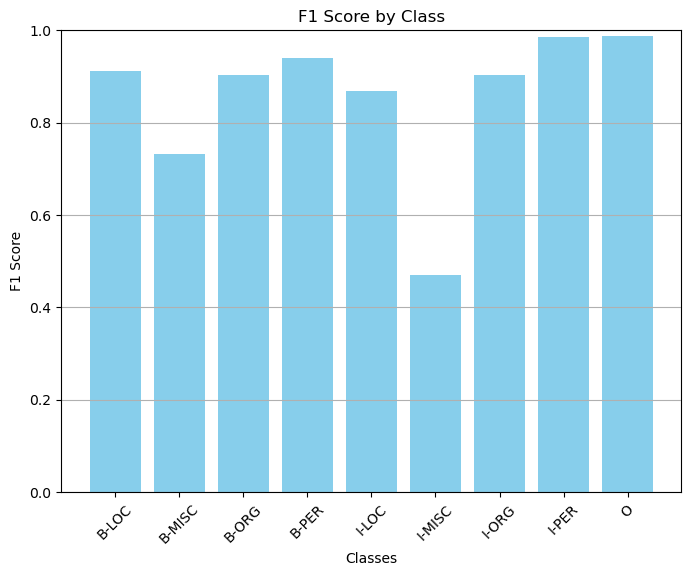

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(flattened_test_labels, flattened_test_preds, output_dict=True)

# Extract class-wise F1-scores
classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
f1_scores = [report[cls]["f1-score"] for cls in classes]

# Bar plot for F1-scores
plt.figure(figsize=(8, 6))
plt.bar(classes, f1_scores, color='skyblue')
plt.xlabel("Classes")
plt.ylabel("F1 Score")
plt.title("F1 Score by Class")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.grid(axis="y")
plt.show()


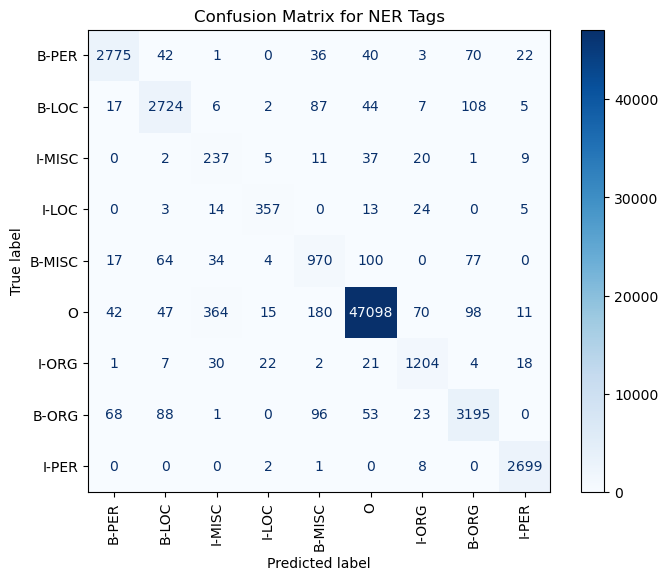

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute confusion matrix
labels = list(set(flattened_test_labels))
cm = confusion_matrix(flattened_test_labels, flattened_test_preds, labels=labels)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax, xticks_rotation="vertical")
plt.title("Confusion Matrix for NER Tags")
plt.show()


In [33]:
# Define a test sentence
test_sentence = "Barack Obama visited Paris."

inputs = tokenizer(
    test_sentence,
    return_tensors="pt",
    truncation=True,
    padding=True,
    is_split_into_words=False
)

# Remove token_type_ids if present
if "token_type_ids" in inputs:
    del inputs["token_type_ids"]

# Move inputs to the appropriate device
inputs = {key: val.to(device) for key, val in inputs.items()}

# Run the model
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# Get predictions
logits = outputs["logits"]
predictions = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()

# Decode predictions back to labels
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().cpu().numpy())
predicted_labels = [label_list[pred] for pred in predictions]

# Print the input and output
print("Test Input Sentence:")
print(test_sentence)
print("\nTokenized Input:")
print(tokens)
print("\nPredicted Labels:")
print(predicted_labels)


Test Input Sentence:
Barack Obama visited Paris.

Tokenized Input:
['[CLS]', 'Barack', 'Obama', 'visited', 'Paris', '.', '[SEP]']

Predicted Labels:
['O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'O', 'B-LOC']


### Model Architecture

In [22]:
import os
import torch

# Define the directory to save the model
save_directory = "./bert_ner_model"
os.makedirs(save_directory, exist_ok=True)

# Save the model
torch.save(model.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

# Save model configuration
with open(os.path.join(save_directory, "config.json"), "w") as f:
    f.write(model.bert.config.to_json_string())

print(f"Model, tokenizer, and configuration saved to {save_directory}")


Model, tokenizer, and configuration saved to ./bert_ner_model


In [24]:
from torchviz import make_dot
from transformers import AutoTokenizer

# Create dummy inputs for the model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
dummy_sentence = "Steve Jobs founded Apple in California."
dummy_inputs = tokenizer(dummy_sentence, return_tensors="pt", padding=True, truncation=True)

# Move inputs to the appropriate device
dummy_inputs = {key: val.to(device) for key, val in dummy_inputs.items()}

# Forward pass through the model
model.eval()
outputs = model(input_ids=dummy_inputs["input_ids"], attention_mask=dummy_inputs["attention_mask"])

# Visualize the computation graph
graph = make_dot(outputs["logits"], params=dict(model.named_parameters()))
graph.render("model_architecture", format="png")

print("Model architecture diagram saved as 'model_architecture.png'.")


Model architecture diagram saved as 'model_architecture.png'.


In [26]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph(comment='Enhanced BERT NER Model Architecture', format="png")

# Add nodes
dot.node('A', 'Input Sentence\n(e.g., "Steve Jobs founded Apple.")', shape='box')
dot.node('B', 'Tokenizer\n(WordPiece Tokenization)', shape='box')
dot.node('C', 'BERT-base Encoder\n(Hidden States for All Layers)', shape='box')
dot.node('D', 'Layer Attention\n(Combine All Layers)', shape='ellipse')
dot.node('E', 'Dropout Layer\n(Regularization)', shape='ellipse')
dot.node('F', 'Fully Connected Layer\n(Classifier)', shape='ellipse')
dot.node('G', 'Output Tags\n(e.g., [B-PER, O, B-ORG])', shape='box')

# Connect nodes
dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG'])

# Render the graph
dot.render('enhanced_bert_ner_model', format="png", cleanup=True)

print("Enhanced model diagram saved as 'enhanced_bert_ner_model.png'.")


Enhanced model diagram saved as 'enhanced_bert_ner_model.png'.


In [36]:
print("Train size:", len(tokenized_datasets["train"]))
print("Validation size:", len(tokenized_datasets["validation"]))
print("Test size:", len(tokenized_datasets["test"]))


Train size: 14041
Validation size: 3250
Test size: 3453


In [38]:
train_labels = set([label for example in tokenized_datasets["train"] for label in example["labels"] if label != -100])
test_labels = set([label for example in tokenized_datasets["test"] for label in example["labels"] if label != -100])
assert train_labels == test_labels, "Train and test labels do not match!"

In [39]:
train_tokens = set(tuple(example["tokens"]) for example in tokenized_datasets["train"])
test_tokens = set(tuple(example["tokens"]) for example in tokenized_datasets["test"])

# Check for overlap
common_tokens = train_tokens & test_tokens
print("Number of overlapping tokens between train and test:", len(common_tokens))
assert len(common_tokens) == 0, "Train and test sets have overlapping tokens!"


Number of overlapping tokens between train and test: 78


AssertionError: Train and test sets have overlapping tokens!